## 1. Modelos Generativos

### 1.1 *Variational Autoencoder* (VAE)

In [1]:
import matplotlib.pyplot as plt
from timeit import default_timer as timer

In [2]:
from keras.datasets import mnist
from keras.layers import Lambda
from keras import backend as K
from keras.layers import Reshape,Conv2DTranspose,Activation
from keras.layers import Input,Conv2D,Flatten,Dense,MaxPool2D
from keras.models import Model
from scipy.stats import norm
import numpy as np
import keras
(X_train, y_train), (X_test, y_test) = mnist.load_data()

/home/difroggy/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
#Falta una dimension correspondiente a los canales, por lo que se agrega
X_train=np.reshape(X_train,(-1,28,28,1))
X_test=np.reshape(X_test,(-1,28,28,1))
###
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
img_rows, img_cols = X_train.shape[1:3]
channel=1

Primero se cargan las imágenes utilizadas en las tareas anteriores. Son imágenes de $28\times28$ en escala de grises con valores en $[0,255]$, escalados para estar entre $[0,1]$.

Parte a)

In [4]:
# input image dimensions
original_img_size = (img_rows, img_cols,channel)
# number of convolutional filters to use
filters = 32
# convolution kernel size
num_conv = 3
latent_dim = 2
intermediate_dim = 128
from keras.layers import Input,Conv2D,Flatten,Dense,MaxPool2D
from keras.models import Model
## Encoder
x = Input(shape=original_img_size)
conv_1 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(conv_1)
conv_3 = Conv2D(filters*2, kernel_size=num_conv, padding='same', activation='relu', strides=2)(conv_2)
flat = Flatten()(conv_3)
hidden = Dense(intermediate_dim, activation='relu')(flat)
z_mean = Dense(latent_dim,activation='linear')(hidden)
z_log_var = Dense(latent_dim,activation='linear')(hidden)
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

In [5]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1605760   
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total para

El modelo mostrado corresponde a la sección codificadora del autoencoder. En primer lugar se tienen tres capas convolucionales y luego unas densas para la reducción de dimensionalidad. La capa densa más pequeña está a conectada con dos capas, *z_mean* y *z_log_var*.

Las capas convolucionales tienen la labor de identificar features de las imágenes, generando feature maps para este motivo. Por otro lado, las capas densas con prefijo "z" tienen la labor de aprender sobre las variables latentes de los datos. Notar que estas últimas tienen de manera predeterminada 2 dimensiones, que indican la evaluación de 2 variables latentes.

Parte b)

**Convolución transpuesta** es el proceso de generar una convolución de datos de menor dimensión a uno de igual o mayor. El proceso no es equivalente a revertir la convolución original (si es que hubo una previamente) pero sí es posible restaurar dimensiones de esta manera.

Los strides indican la distancia con la que se encuentran los datos originales, por ejemplo en el caso de las imágenes, con stride 1 la convolución será hecha sobre la imagen original, mientras que con stride 2 cada dato tendrá un pixel de distancia.

In [6]:
from keras import backend as K
from keras.layers import Reshape,Conv2DTranspose,Activation
## Decoder
shape_before_flattening = K.int_shape(conv_3)[1:]
# we instantiate these layers separately so as to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(np.prod(shape_before_flattening), activation='relu')
decoder_reshape = Reshape(shape_before_flattening)
decoder_deconv_1 = Conv2DTranspose(filters,kernel_size=num_conv, padding='same',strides=2,activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters,kernel_size=num_conv,padding='same', activation='relu')
decoder_mean_squash = Conv2DTranspose(channel, kernel_size=num_conv,padding='same', activation='sigmoid')

En este caso, como se utiliza padding *same*, la imagen resultante tendrá las mismas dimensiones que la original.

Parte c)

In [7]:
def sampling(args):
    epsilon_std = 1.0
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon
from keras.layers import Lambda
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded =  decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
x_decoded_relu = decoder_deconv_2(deconv_1_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)
# instantiate VAE model
vae = Model(x, x_decoded_mean_squash)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten_1 

El modelo completo es el *Variational Autoencoder*. Este primero recibe una imagen de $28\times28$ y a través de convoluciones disminuye sus dimensiones a $14\times14$ con 64 canales. Luego se llevan a capas densas con 1 dimensión de 12,544 elementos y posteriormente se disminuye a 128 elementos. Toda esta sección corresponde al encoder del modelo.

Las capas *dense_20* y *dense_21* ambas están conectadas a la salida de 128 elementos y tienen la labor de aprender sobre las variables latentes de los datos originales.

En la entrada de la sección de decoding, el modelo posee una capa *lambda_4* que toma como argumentos las variables latentes y las utiliza para otorgar variaciones a las imágenes producidas. Finalmente esta imagen modificada, con baja dimensionalidad luego es aumentada con capas densas y convoluciones transpuestas, utilizando las mismas dimensiones que en la sección de enconding.

Parte d)

La función de pérdida elegida fue *Binary-crossentropy*. Si bien estas funciones tienen usos particulares, como esta en clasificación y MSE en regresión, ambas son viables para motivos de este modelo.

In [8]:
# Compute VAE loss
#choised_loss =  keras.metrics.binary_crossentropy(K.flatten(x),K.flatten(x_decoded_mean_squash))
choised_loss =  keras.metrics.mean_squared_error(K.flatten(x),K.flatten(x_decoded_mean_squash))
reconstruction_loss = img_rows * img_cols * channel* choised_loss
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten_1 

KL-divergencia indica la diferencia entre dos tipos de distribuciones, con valor máximo $1$ cuando el comportamiento de las distribuciones son muy distintas. Por otro lado, con valor $0$ estas se comportan de manera parecida, si no idénticamente.

Por lo anterior, utilizar KL-divergencia ofrece una forma fácil para identificar las variables latentes de los datos originales y por extensión reconocer su distribución.

Parte e)

In [9]:
batch_size = 128
epochs =15
vae.compile(optimizer='rmsprop')
vae.fit(X_train,epochs=epochs, batch_size=batch_size,validation_data=(X_test, None))

/home/difroggy/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Output "conv2d_transpose_3" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "conv2d_transpose_3" during training.
  This is separate from the ipykernel package so we can avoid doing imports until


Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 38s 634us/step - loss: 45.7611 - val_loss: 39.6867
Epoch 2/15
60000/60000 [==============================] - 23s 379us/step - loss: 38.8962 - val_loss: 37.4535
Epoch 3/15
60000/60000 [==============================] - 22s 374us/step - loss: 37.0914 - val_loss: 37.1036
Epoch 4/15
60000/60000 [==============================] - 22s 372us/step - loss: 36.1404 - val_loss: 35.9264
Epoch 5/15
60000/60000 [==============================] - 22s 373us/step - loss: 35.4824 - val_loss: 34.8612
Epoch 6/15
60000/60000 [==============================] - 22s 372us/step - loss: 34.9957 - val_loss: 34.5193
Epoch 7/15
60000/60000 [==============================] - 22s 372us/step - loss: 34.5828 - val_loss: 34.9567
Epoch 8/15
60000/60000 [==============================] - 22s 373us/step - loss: 34.1894 - val_loss: 33.9345
Epoch 9/15
60000/60000 [==============================] - 22s 373us/step - los

Parte f)

Se genera el gráfico de la representación en el espacio latente de cada número.

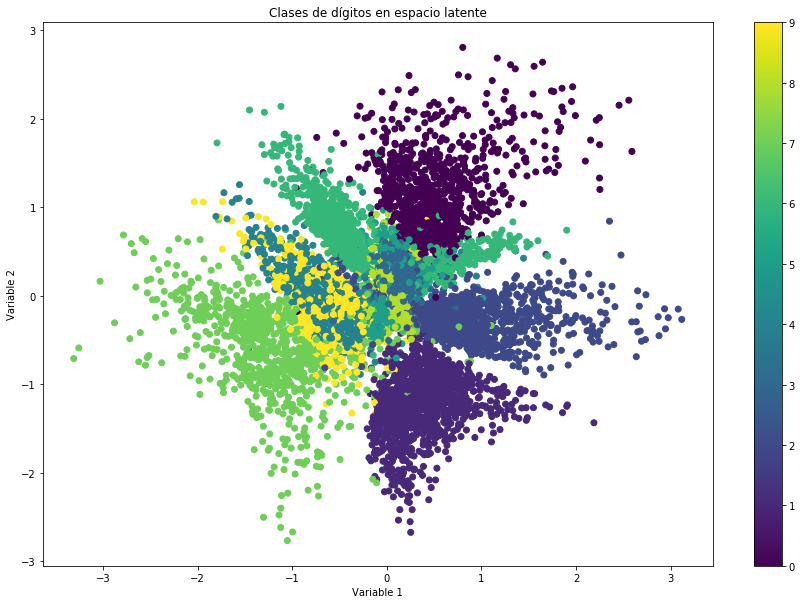

In [10]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(X_test, batch_size=batch_size)
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.title("Clases de dígitos en espacio latente")
plt.xlabel("Variable 1")
plt.ylabel("Variable 2")
plt.colorbar()
plt.show()

En la figura se puede observar como números de distintas categorías tienden a agruparse en el espacio latente, siendo más evidente en números como el 0 y el 1. Algunas clases se mezclan, como es el caso del 9, que comparte espacio con clases como el 4 y el 7.

Más importante, notar que en general todas las clases están cercanas unas a otras, lo cuál indica que el modelo es capaz de producir imágenes intermedias (que se mueven dentro del espacio ilustrado) y que además este mismo pueda interpretar como una clase (o número, en este caso). Variaciones que disten mucho del centro corresponderían a imágenes inentendibles por el modelo.

Luego se generan los histogramas de las medias y el logaritmo de las varianzas de las variables latentes.

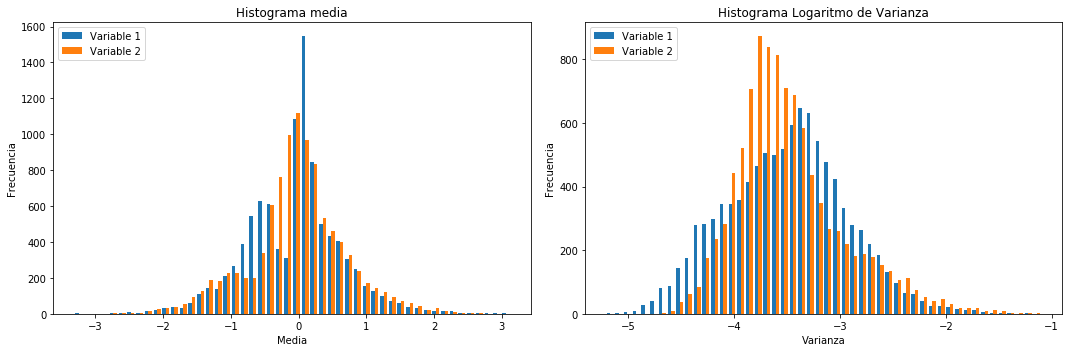

In [16]:
encoder_log_var = Model(x,z_log_var)
#histogram
x_test_log_var=encoder_log_var.predict(X_test,batch_size=batch_size)
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
ax = axes.flatten()
leg=["Variable 1","Variable 2"]
ax[0].hist(x_test_encoded, 50)
ax[1].hist(x_test_log_var, 50)
ax[0].set_title('Histograma media')
ax[0].set_ylabel('Frecuencia')
ax[0].set_xlabel('Media')
ax[0].legend(leg, loc='upper left')
ax[1].set_title('Histograma Logaritmo de Varianza')
ax[1].set_ylabel('Frecuencia')
ax[1].set_xlabel('Varianza')
ax[1].legend(leg, loc='upper left')
plt.tight_layout()
plt.show()

En el histograma de medias se puede apreciar que ambas variables están cercanas al cero, con la variable 2 un poco más desplazada hacia los negativos. Esta evaluación coincide con el sampleo utilizado en la función lambda del modelo, cuya media también es 0.

El histograma indica la distribución de los números respecto al espacio latente, lo cuál es equivalente a considerar solamente un eje en términos posicionales y presentarlos en función a su frecuencia.

Notar que la salida es el logaritmo natural de la varianza, por lo tanto para encontrar el centro de la distribucioń de la varianza se debe aplicar exponencial a este valor.

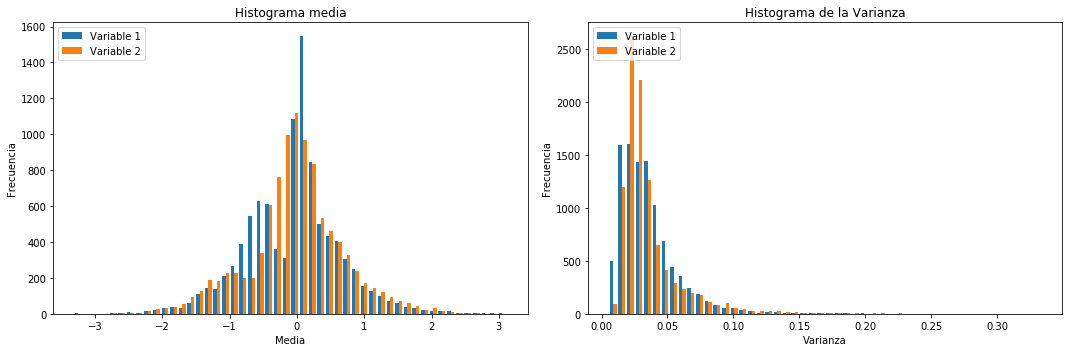

In [24]:
x_test_log_var=encoder_log_var.predict(X_test,batch_size=batch_size)
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
ax = axes.flatten()
leg=["Variable 1","Variable 2"]
ax[0].hist(x_test_encoded, 50)
ax[1].hist(np.exp(x_test_log_var), 50)
ax[0].set_title('Histograma media')
ax[0].set_ylabel('Frecuencia')
ax[0].set_xlabel('Media')
ax[0].legend(leg, loc='upper left')
ax[1].set_title('Histograma de la Varianza')
ax[1].set_ylabel('Frecuencia')
ax[1].set_xlabel('Varianza')
ax[1].legend(leg, loc='upper left')
plt.tight_layout()
plt.show()

Como es esperado, la varianza de la distribución es superior a 0, y se centran, para ambas variables, aproximadamente en 0.025.

Parte g)

La siguiente figura es equivalente a la figura de puntos en el ítem anterior, sin embargo en lugar de ilustrar puntos, se presentan los símbolos de salida que produce el modelo. Para comparar se presentan los gráficos uno tras otro. 

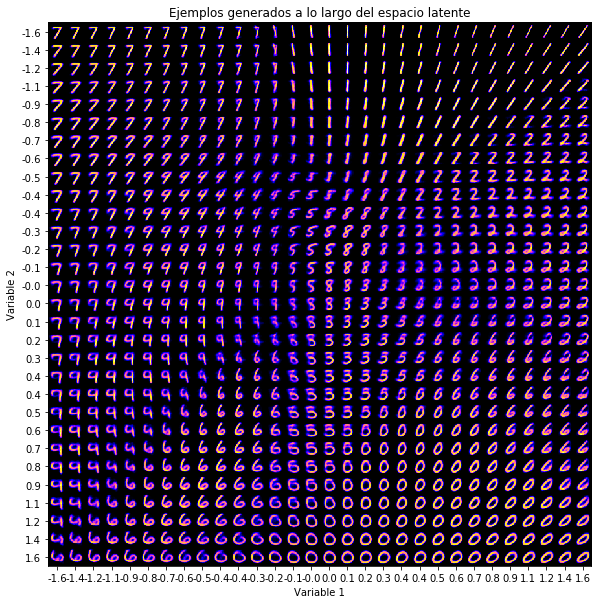

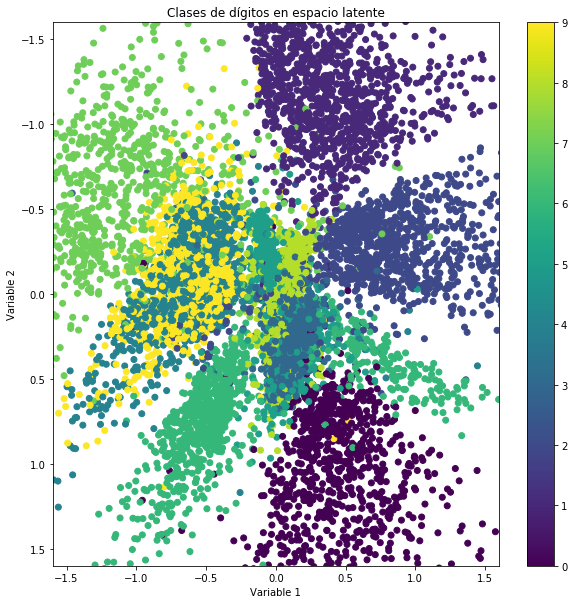

In [12]:
#GENERATOR
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_x_decoded_relu = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash)
##PLOT
n = 30  # figure with 15x15 images 
image_size = img_cols
figure = np.zeros((image_size * n, image_size * n))
from scipy.stats import norm
#metodo de la transformada inversa
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])            
        x_decoded = generator.predict(z_sample,batch_size=batch_size)
        figure[i * image_size: (i + 1) * image_size,
               j * image_size: (j + 1) * image_size] = x_decoded[0][:,:,0]
plt.figure(figsize=(10, 10))
plt.imshow(figure,cmap='gnuplot2')
pos = np.arange(image_size/2,image_size*n,image_size)
plt.yticks(pos,np.round(grid_y,1))
plt.xticks(pos,np.round(grid_x,1))
plt.title("Ejemplos generados a lo largo del espacio latente")
plt.xlabel("Variable 1")
plt.ylabel("Variable 2")
plt.show()

x_test_encoded = encoder.predict(X_test, batch_size=batch_size)
plt.figure(figsize=(10,10))
plt.xlim(-1.6,1.6)
plt.ylim(1.6,-1.6)
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.title("Clases de dígitos en espacio latente")
plt.xlabel("Variable 1")
plt.ylabel("Variable 2")
plt.colorbar()
plt.show()

Ambos gráficos representan el espacio latente, y se puede observar una correspondencia entre la ubicación del área clasificada como *uno* en el gráfico de dispersión y símbolos parecidos a unos en el de ejemplos.

Además, áreas que están altamente pobladas por puntos mezclados presentan combinaciones de símbolos en el primer gráfico, particularmente con los *nueves*. Esto denota la dificultad de identificación que tiene el modelo frente a estos números.

Luego, se produce el mismo gráfico aumentando el intervalo de confianza.

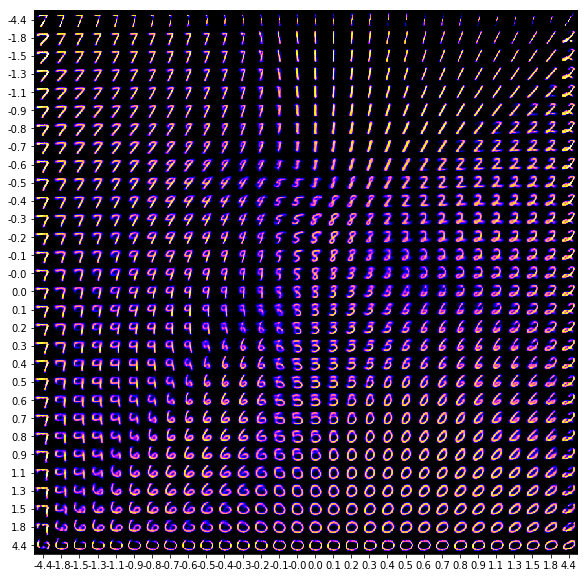

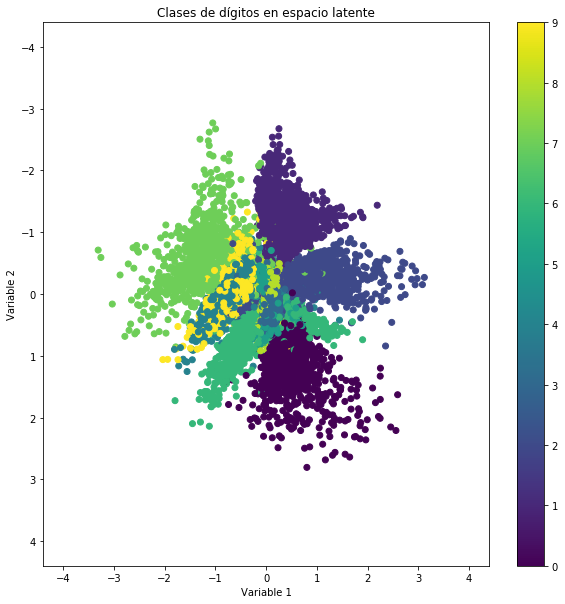

In [13]:
#en los extremos del intervalo de confianza
grid = norm.ppf(np.linspace(0.000005, 0.999995, n))
grid_x = grid
grid_y = grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])            
        x_decoded = generator.predict(z_sample,batch_size=batch_size)
        figure[i * image_size: (i + 1) * image_size,
               j * image_size: (j + 1) * image_size] = x_decoded[0][:,:,0]
plt.figure(figsize=(10, 10))
plt.imshow(figure,cmap='gnuplot2')
pos = np.arange(image_size/2,image_size*n,image_size)
plt.yticks(pos,np.round(grid_y,1))
plt.xticks(pos,np.round(grid_x,1))
plt.show()
x_test_encoded = encoder.predict(X_test, batch_size=batch_size)
plt.figure(figsize=(10,10))
plt.xlim(-4.4,4.4)
plt.ylim(4.4,-4.4)
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.title("Clases de dígitos en espacio latente")
plt.xlabel("Variable 1")
plt.ylabel("Variable 2")
plt.colorbar()
plt.show()

En los extremos se ilustran símbolos no encontrados en el conjunto de datos, como bien indica el gráfico de dispersión. Estos símbolos, sobretodo en las esquinas de la figura, son distorsiones de los símbolos originales y resultan de una "saturación" en las variables latentes, resultando en variaciones extremas y distantes del set de datos original.

Parte i)

Para comprobar el impacto de la dimensionalidad en el desempeño del modelo, sencillamente se compararán las pérdidas de cada modelo durante entrenamiento.

In [28]:
historias=[]
dimensiones=[2,3,4,5,8,10,20]
modelos1=[]
modelos2=[]
for latent_dim in dimensiones:
    start=timer()
    x = Input(shape=original_img_size)
    conv_1 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(x)
    conv_2 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(conv_1)
    conv_3 = Conv2D(filters*2, kernel_size=num_conv, padding='same', activation='relu', strides=2)(conv_2)
    flat = Flatten()(conv_3)
    hidden = Dense(intermediate_dim, activation='relu')(flat)
    z_mean = Dense(latent_dim,activation='linear')(hidden)
    z_log_var = Dense(latent_dim,activation='linear')(hidden)
    modelos1.append(Model(x,z_mean))
    modelos2.append(Model(x,z_log_var))
    # build a model to project inputs on the latent space
    encoder = Model(x, z_mean)


    decoder_hid = Dense(intermediate_dim, activation='relu')
    decoder_upsample = Dense(np.prod(shape_before_flattening), activation='relu')
    decoder_reshape = Reshape(shape_before_flattening)
    decoder_deconv_1 = Conv2DTranspose(filters,kernel_size=num_conv, padding='same',strides=2,activation='relu')
    decoder_deconv_2 = Conv2DTranspose(filters,kernel_size=num_conv,padding='same', activation='relu')
    decoder_mean_squash = Conv2DTranspose(channel, kernel_size=num_conv,padding='same', activation='sigmoid')



    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
    hid_decoded = decoder_hid(z)
    up_decoded = decoder_upsample(hid_decoded)
    reshape_decoded =  decoder_reshape(up_decoded)
    deconv_1_decoded = decoder_deconv_1(reshape_decoded)
    x_decoded_relu = decoder_deconv_2(deconv_1_decoded)
    x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)
    # instantiate VAE model
    vae = Model(x, x_decoded_mean_squash)


    #choised_loss =  keras.metrics.binary_crossentropy(K.flatten(x),K.flatten(x_decoded_mean_squash))
    choised_loss =  keras.metrics.mean_squared_error(K.flatten(x),K.flatten(x_decoded_mean_squash))
    reconstruction_loss = img_rows * img_cols * channel* choised_loss
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)

    batch_size = 128
    epochs =10
    vae.compile(optimizer='rmsprop',metrics=['accuracy'])
    hist=vae.fit(X_train,epochs=epochs, batch_size=batch_size,validation_data=(X_test, None),verbose=0)
    historias.append(hist)
    end=timer()
    diferencia=end-start
    print("Tiempo de ejecución para {} dimensiones: {} seg".format(latent_dim,diferencia))

/home/difroggy/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Output "conv2d_transpose_9" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "conv2d_transpose_9" during training.


Tiempo de ejecución para 2 dimensiones: 221.73373109000022 seg


/home/difroggy/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Output "conv2d_transpose_12" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "conv2d_transpose_12" during training.


Tiempo de ejecución para 3 dimensiones: 218.86083171000018 seg


/home/difroggy/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Output "conv2d_transpose_15" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "conv2d_transpose_15" during training.


Tiempo de ejecución para 4 dimensiones: 220.30674474199986 seg


/home/difroggy/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Output "conv2d_transpose_18" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "conv2d_transpose_18" during training.


Tiempo de ejecución para 5 dimensiones: 220.22384832700027 seg


/home/difroggy/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Output "conv2d_transpose_21" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "conv2d_transpose_21" during training.


Tiempo de ejecución para 8 dimensiones: 219.4651759770004 seg


/home/difroggy/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Output "conv2d_transpose_24" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "conv2d_transpose_24" during training.


Tiempo de ejecución para 10 dimensiones: 219.16708975599977 seg


/home/difroggy/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Output "conv2d_transpose_27" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "conv2d_transpose_27" during training.


Tiempo de ejecución para 20 dimensiones: 219.86033758299982 seg


Como la función de pérdida está asociada a la divergencia de las funciones, una menor pérdida implicará un mejor acercamiento a la distribución de datos.

Se procede a graficar las pérdidas de entrenamiento y de validación.

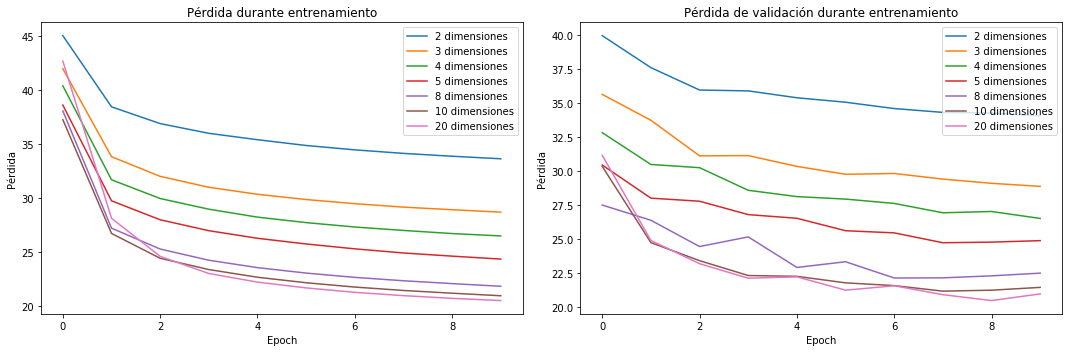

In [30]:
leg=[]
for i in range(len(dimensiones)):
    leg.append(str(dimensiones[i])+" dimensiones")
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
ax = axes.flatten()
for i in range(len(historias)):
    ax[0].plot(historias[i].history["loss"])
    ax[1].plot(historias[i].history["val_loss"])
ax[0].set_title('Pérdida durante entrenamiento')
ax[0].set_ylabel('Pérdida')
ax[0].set_xlabel('Epoch')
ax[0].legend(leg, loc='upper right')
ax[1].set_title('Pérdida de validación durante entrenamiento')
ax[1].set_ylabel('Pérdida')
ax[1].set_xlabel('Epoch')
ax[1].legend(leg, loc='upper right')
plt.tight_layout()
plt.show()

En los gráficos se puede apreciar que se disminuye le pérdida de las funciones conforme más variables latentes se consideren en el modelo. Esto se puede atribuir a que al considerar más variables, más información latente puede aprender el modelo.

Notar que existe una cota para la cantidad de variables necesarias, notando que con 8, 10 y 20 variables latentes no existe mayor mejora tras los 2 epochs, por lo que se infiere que dependiendo de la naturaleza de los datos, existe una cantidad de variables latentes adecuadas que pueden contener gran parte de la información latente.

Luego se hace el histograma considerando a todas las dimensiones.

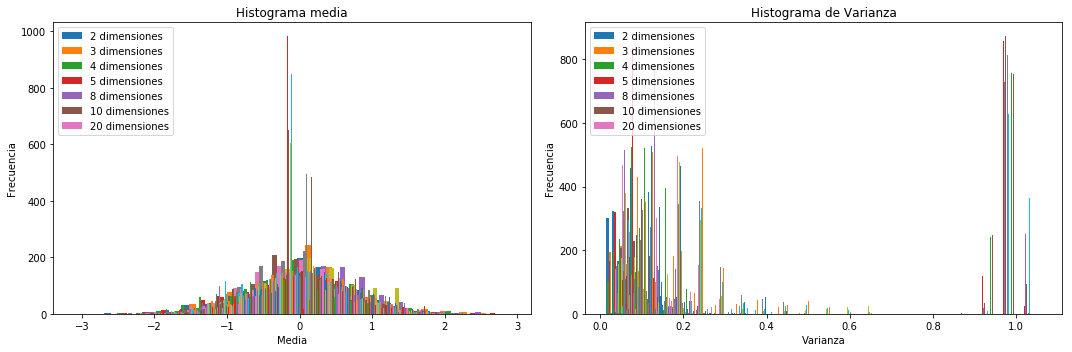

In [41]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
ax = axes.flatten()
leg=[]
for i in range(len(dimensiones)):
    leg.append(str(dimensiones[i])+" dimensiones")
ax[0].set_title('Histograma media')
ax[0].set_ylabel('Frecuencia')
ax[0].set_xlabel('Media')
ax[1].set_title('Histograma de Varianza')
ax[1].set_ylabel('Frecuencia')
ax[1].set_xlabel('Varianza')

#histogram
for i in range(len(dimensiones)):
    x_test_encoded=modelos1[i].predict(X_test[:1000],batch_size=batch_size)
    x_test_log_var=modelos2[i].predict(X_test[:1000],batch_size=batch_size)
    ax[0].hist(x_test_encoded,20)
    ax[1].hist(np.exp(x_test_log_var),20)
ax[0].legend(leg, loc='upper left')
ax[1].legend(leg, loc='upper left')
plt.tight_layout()
plt.show()

Debido a que son muchos datos en el histograma, es difícil discernir exactamente cuáles son las anomalías respecto a cada dimensión, sin embargo sí se puede afirmar que salvo algunos casos, la media de las variables latentes actúa como una distribución normal centrada en 0.

Además, en las varianzas se observa que esta se concentra sobretodo entre 0 y 0.2 para todas las dimensiones, salvo algunas discrepancias con varianza 1.0.

Por lo anterior se puede inferir a partir del primer gráfico que en general las imágenes reconstruidas por el autoencoder siguen la distribución original de datos, que en este caso es gaussiana.

Parte j)

Un acercamiento inicial, a modo de experimentación, es ocupar un encoder que consiste exclusivamente en capas densas para disminuir la dimensionalidad y luego para aumentarla.

In [219]:
x = Input(shape=original_img_size)
flat=Flatten()(x)
Dense_1=Dense(784,activation='relu')(flat)
Dense_2=Dense(196,activation='relu')(Dense_1)
Drop1=Dropout(0.25)(Dense_2)
Dense_3=Dense(49,activation='relu')(Drop1)
hidden = Dense(intermediate_dim, activation='relu')(Dense_3)
z_mean = Dense(latent_dim,activation='linear')(hidden)
z_log_var = Dense(latent_dim,activation='linear')(hidden)
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

decoder_hid = Dense(intermediate_dim, activation='relu')
Dense_4=Dense(49,activation='relu')
Dense_5=Dense(196,activation='relu')
Drop2=Dropout(0.25)
Dense_6=Dense(784,activation='sigmoid')

dec_int=decoder_hid(z)
Layer_d4=Dense_4(dec_int)
Layer_d5=Dense_5(Layer_d4)
Layer_drop2=Drop2(Layer_d5)
Layer_d6=Dense_6(Layer_drop2)
Reshap=Reshape(original_img_size)(Layer_d6)

vae2 = Model(x, Reshap)

#choised_loss =  keras.metrics.binary_crossentropy(K.flatten(x),K.flatten(x_decoded_mean_squash))
choised_loss =  keras.metrics.mean_squared_error(K.flatten(x),K.flatten(Reshap))
reconstruction_loss = img_rows * img_cols * channel* choised_loss
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae2_loss = K.mean(reconstruction_loss + kl_loss)
vae2.add_loss(vae_loss)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
flatten_23 (Flatten)            (None, 784)          0           input_32[0][0]                   
__________________________________________________________________________________________________
dense_124 (Dense)               (None, 784)          615440      flatten_23[0][0]                 
__________________________________________________________________________________________________
dense_125 (Dense)               (None, 196)          153860      dense_124[0][0]                  
__________________________________________________________________________________________________
dropout_15

El modelo es entrenado.

In [ ]:
batch_size = 128
epochs =10
vae.compile(optimizer='rmsprop',metrics=['accuracy'])
hist=vae.fit(X_train,epochs=epochs, batch_size=batch_size,validation_data=(X_test, None))

Luego se produce el gráfico de las clases en el espacio latente.

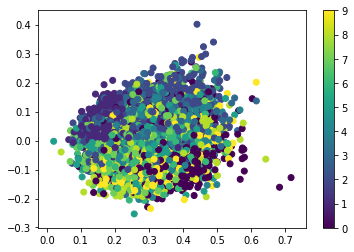

In [208]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(X_test, batch_size=batch_size)
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()
encoder_log_var = Model(x,z_log_var)
#histogram

Se puede observar de manera cualitativa de que el modelo no tiene buenos resultados, generando imágenes que a lo largo del espacio latente no posee una agrupación consistente respecto a las clases con que el modelo las identifica.

Se repite el proceso de generar ejemplos sobre el espacio latente para observar los datos.

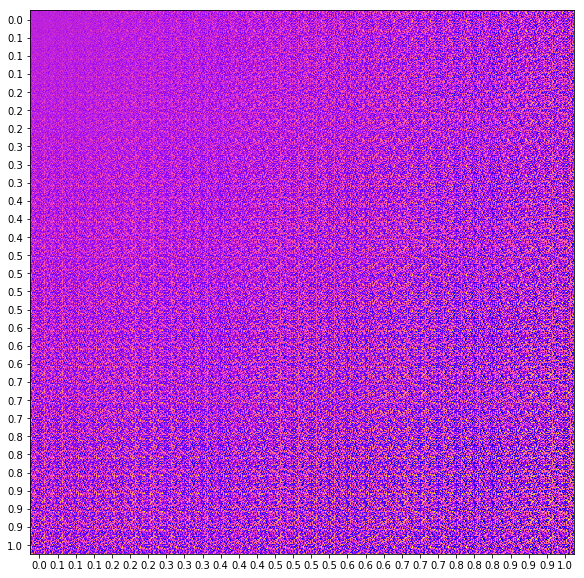

In [218]:
latent_dim=2
#GENERATOR
decoder_input = Input(shape=(latent_dim,))
_dec_int=decoder_hid(decoder_input)
_Layer_d4=Dense_4(_dec_int)
_Layer_d5=Dense_5(_Layer_d4)
_Layer_drop2=Drop2(_Layer_d5)
_Layer_d6=Dense_6(_Layer_drop2)
_Reshap=Reshape(original_img_size)(_Layer_d6)

generator = Model(decoder_input, _Reshap)

##PLOT
n = 30  # figure with 15x15 images 
image_size = img_cols
figure = np.zeros((image_size * n, image_size * n))
#metodo de la transformada inversa
grid_x = uniform.ppf(np.linspace(0.05, 0.95, n))
grid_y = uniform.ppf(np.linspace(0.05, 0.95, n))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])            
        x_decoded = generator.predict(z_sample,batch_size=batch_size)
        figure[i * image_size: (i + 1) * image_size,
               j * image_size: (j + 1) * image_size] = x_decoded[0][:,:,0]
plt.figure(figsize=(10, 10))
plt.imshow(figure,cmap='gnuplot2')
pos = np.arange(image_size/2,image_size*n,image_size)
plt.yticks(pos,np.round(grid_y,1))
plt.xticks(pos,np.round(grid_x,1))
plt.show()

La visualización de ejemplos solamente presenta basura, lo cuál es indicador de que un autoencoder variacional que consiste exclusivamente en capas densas no es una arquitectura viable para un autoencoder, y mucho menos para aprender la distribución de los datos.

### 1.2 *Generative Adversarial Networks* (GAN)

Parte a)

El discriminador es la sección que se encarga de decidir si la imagen recibidad corresponde o no a una imagen generada por el generador.

In [230]:
from keras.models import Model,Sequential
from keras.layers import LeakyReLU,Conv2D,Dropout,Flatten,Dense
## Discriminator
D = Sequential()
depth = 64
dropout = 0.4
input_shape = (img_rows, img_cols, channel)
D.add(Conv2D(depth*1, (5,5), strides=2, input_shape=input_shape,padding='same', activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(dropout))
D.add(Conv2D(depth*2, (5,5), strides=2, padding='same',activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(dropout))
D.add(Conv2D(depth*4, (5,5), strides=2, padding='same',activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(dropout))
D.add(Flatten())
D.add(Dense(1024,activation=LeakyReLU(alpha=0.2)))
D.add(Dense(1,activation='sigmoid'))
D.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_61 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_23 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_24 (Dropout)         (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_25 (Dropout)         (None, 4, 4, 256)         0         
_________________________________________________________________
flatten_26 (Flatten)         (None, 4096)              0         
__________

/home/difroggy/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/keras/activations.py:115: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


La estructura del discriminador consiste en una serie de capas convolucionales con dropout, seguidas por capas densas. Las capas convolucionales son ocupadas para reconocer los patrones de los datos de entrada, mientras que las capas densas tienen la labor de discriminar las imágenes.

Tanto las capas convolucionales como la capa densa con múltiples unidades poseen unidades *LeakyReLU*, las cuales son utilizadas como alternativa a las ReLU tradicionales por evitar el estancamiento de la propagación de la gradiente al permitir el paso de pequeños valores negativos.

Finalmente la salida utiliza función sigmoidal pues genera una salida completa, abarcando un rango de valores continuo, en contraste con ReLU que lleva a 0 cualquier valor bajo cierto margen de activación.

Parte b)

El generador se encarga producir imágenes falsas, con la esperanza de que eventualmente logre engañar al discriminador y por extensión aprender la distribución de los datos.

In [231]:
from keras.layers import BatchNormalization,Reshape,UpSampling2D,Conv2DTranspose,Activation
## Generator
G = Sequential()
dim = 14
input_dim= 2 #para que sea similar al vAE
G.add(Dense(128, input_dim=input_dim))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Dense(dim*dim*depth))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Reshape((dim, dim, depth)))
G.add(Conv2DTranspose(int(depth/2), (3,3), padding='same',strides=(2,2)))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Conv2DTranspose(int(depth/2), (3,3), padding='same'))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Conv2DTranspose(channel, (3,3), padding='same')) 
G.add(Activation('sigmoid')) 
G.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_144 (Dense)            (None, 128)               384       
_________________________________________________________________
batch_normalization_17 (Batc (None, 128)               512       
_________________________________________________________________
activation_21 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_145 (Dense)            (None, 12544)             1618176   
_________________________________________________________________
batch_normalization_18 (Batc (None, 12544)             50176     
_________________________________________________________________
activation_22 (Activation)   (None, 12544)             0         
_________________________________________________________________
reshape_28 (Reshape)         (None, 14, 14, 64)        0         
__________

El generador toma como entrada ruido aleatorio, y a este se le aplica *batch_normalization* y función de activación *ReLU*. Luego se aumenta la dimensionalidad utilizando sencillamente una capa densa con las unidades necesarias para formar una imagen de $14\times14$ con 64 canales. Finalmente se utilizan convoluciones transpuestas, cuya función es la misma que las convoluciones tradicionales, sólo que admitiendo convoluciones desde dimensiones más bajas.

Parte c)

In [232]:
from keras.optimizers import RMSprop
## Discriminator model (police)
optimizer = RMSprop(lr=0.0008, clipvalue=1.0, decay=6e-8)
DM = Sequential()
DM.add(D)
DM.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
## Adversarial model (Generator->Discriminator)
D.trainable=False #set the discriminator freeze  (fixed params)
optimizer = RMSprop(lr=0.0004, clipvalue=1.0, decay=3e-8)
AM = Sequential()
AM.add(G)
AM.add(D)
AM.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])

Parte d)

Se entrena la red generativa adversaria, utilizando la función indicada por el enunciado.

In [233]:
def train_on_steps(X_train,DM,AM,G,train_steps,batch_size):
    history = {"d":[],"g":[]}
    for e in range(train_steps):
        # Make generative images
        image_batch = X_train[np.random.randint(0,X_train.shape[0],size=batch_size),:,:,:] #sample images from real data
        noise_gen = np.random.uniform(-1,1,size=[batch_size,input_dim]) #sample image from generated data
        generated_images = G.predict(noise_gen) #fake images
        # Train discriminator on generated images
        X = np.concatenate((image_batch, generated_images))
        #create labels
        y = np.ones([2*batch_size,1])
        y[batch_size:,:] = 0
        d_loss  = DM.train_on_batch(X,y)
        history["d"].append(d_loss)
        # train Generator-Discriminator stack on input noise to non-generated output class
        noise_tr = np.random.uniform(-1,1,size=[batch_size,input_dim])
        y = np.ones([batch_size, 1])
        g_loss = AM.train_on_batch(noise_tr, y)
        history["g"].append(g_loss)
        log_mesg = "%d: [D loss: %f, acc: %f]" % (e, d_loss[0], d_loss[1])
        log_mesg = "%s  [G loss: %f, acc: %f]" % (log_mesg, g_loss[0], g_loss[1])
        if(e%100==0):
            print(log_mesg)
    return history
train_steps = 5000 #or few if  you want
start = timer()
hist = train_on_steps(X_train,DM,AM,G,train_steps,128)
end = timer()
diferencia=end-start
print("Tiempo de ejecución: {} seg".format(diferencia))

/home/difroggy/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0: [D loss: 0.691465, acc: 0.570312]  [G loss: 7.584546, acc: 0.000000]
100: [D loss: 0.368356, acc: 0.875000]  [G loss: 2.283768, acc: 0.000000]
200: [D loss: 0.479741, acc: 0.753906]  [G loss: 1.490289, acc: 0.000000]
300: [D loss: 0.536910, acc: 0.703125]  [G loss: 1.158134, acc: 0.242188]
400: [D loss: 0.378711, acc: 0.816406]  [G loss: 3.070883, acc: 0.000000]
500: [D loss: 0.459816, acc: 0.757812]  [G loss: 0.603058, acc: 0.695312]
600: [D loss: 0.399543, acc: 0.808594]  [G loss: 0.826141, acc: 0.445312]
700: [D loss: 0.434755, acc: 0.757812]  [G loss: 2.380388, acc: 0.039062]
800: [D loss: 0.355001, acc: 0.839844]  [G loss: 1.051174, acc: 0.289062]
900: [D loss: 0.370975, acc: 0.835938]  [G loss: 0.808379, acc: 0.468750]
1000: [D loss: 0.833932, acc: 0.699219]  [G loss: 1.370826, acc: 0.070312]
1100: [D loss: 0.290429, acc: 0.875000]  [G loss: 1.079231, acc: 0.289062]
1200: [D loss: 0.282745, acc: 0.890625]  [G loss: 1.084476, acc: 0.296875]
1300: [D loss: 0.290229, acc: 0.87109

Dado que se entrenan tanto el discriminador como el modelo adversario, se espera que ambos mejoren en desempeño, sin embargo dado que ninguno de los dos componentes cruciales del modelo están entrenados, es posible que exista estancamiento dado que el generador provee imágenes falsas pero sin referencia previa para utilizar como entrenamiento al discriminador.

Luego se producen gráficos a partir de los valores registrados durante entrenamiento.

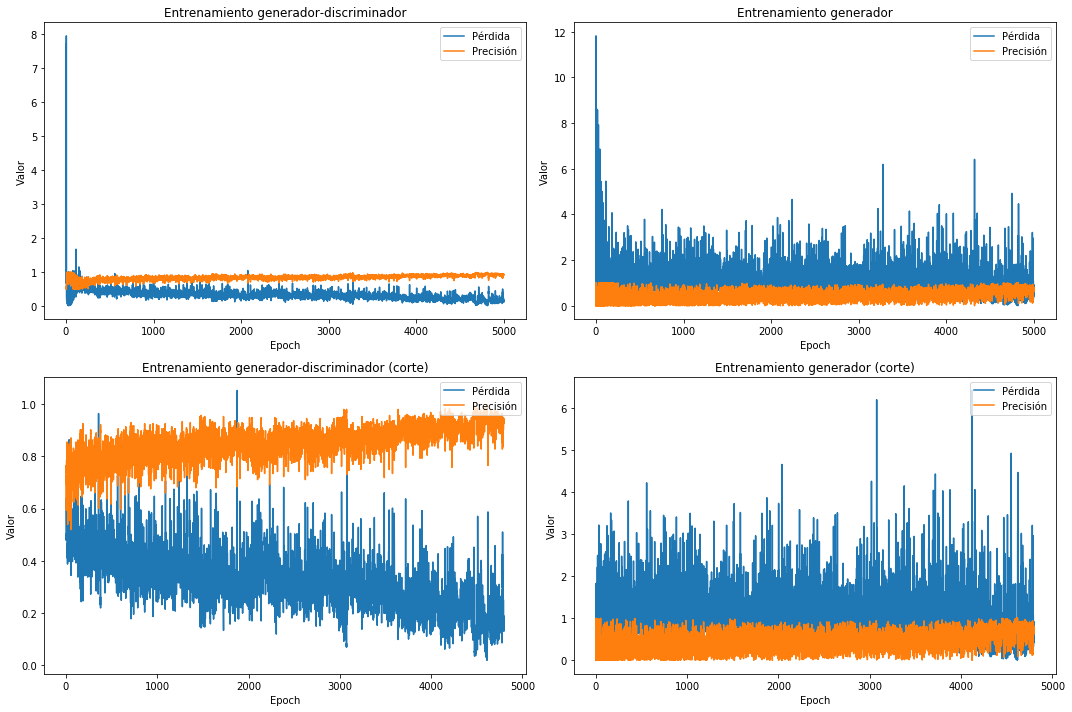

In [240]:
leg=("Pérdida","Precisión")
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15,10))
ax = axes.flatten()
ax[0].set_title("Entrenamiento generador-discriminador")
ax[1].set_title("Entrenamiento generador")
ax[2].set_title("Entrenamiento generador-discriminador (corte)")
ax[3].set_title("Entrenamiento generador (corte)")
ax[0].plot(hist["d"])
ax[1].plot(hist["g"])
ax[2].plot(hist["d"][200:])
ax[3].plot(hist["g"][200:])
for i in range(4):
    ax[i].set_ylabel('Valor')
    ax[i].set_xlabel('Epoch')
    ax[i].legend(leg, loc='upper right')
plt.tight_layout()
plt.show()

Se puede observar que el modelo que más cambios presenta es el discriminador, el cuál mejora de manera constante su precisión y disminuye lentamente su pérdida. El modelo adversario muestra un comportamiento similar en cuanto a su precisión, lentamente mejorando su precisión, sin embargo la pérdida de este es más difícil de apreciar debido a su alta variabilidad.

La mejora marginal de los modelos a lo largo de 5000 epochs puede deberse a lo anteriormente indicado, como ninguno de los dos componentes está debidamente entrenado, se realentiza el aprendizaje de ambos.

Además se hace un gráfico para comparar las precisiones y pérdidas de ambos modelos.

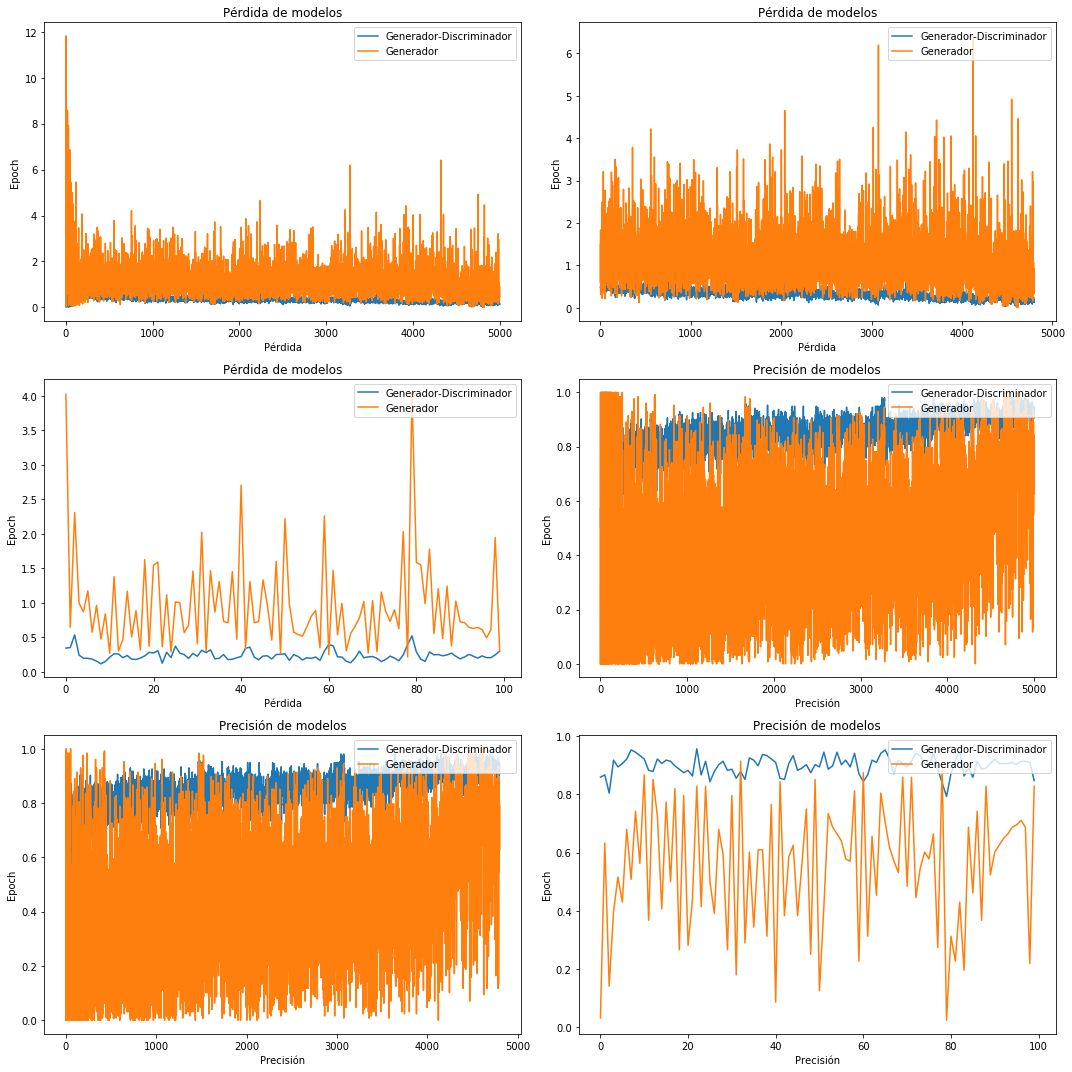

In [241]:
isThis=[]
acc=[]
for i in range(len(hist["d"])):
    isThis.append((hist["d"][i][0],hist["g"][i][0]))
    acc.append((hist["d"][i][1],hist["g"][i][1]))
leg=["Generador-Discriminador","Generador"]
fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(15,15))
ax = axes.flatten()
ax[0].plot(isThis)
ax[1].plot(isThis[200:])
ax[2].plot(isThis[4000:4100])
ax[3].plot(acc)
ax[4].plot(acc[200:])
ax[5].plot(acc[4000:4100])
for i in range(6):
    if(i<3):
        ax[i].set_title('Pérdida de modelos')
        ax[i].set_ylabel('Epoch')
        ax[i].set_xlabel('Pérdida')
        ax[i].legend(leg, loc='upper right')
    else:
        ax[i].set_title('Precisión de modelos')
        ax[i].set_ylabel('Epoch')
        ax[i].set_xlabel('Precisión')
        ax[i].legend(leg, loc='upper right')

plt.tight_layout()
plt.show()

Del gráfico se puede apreciar que los valores de pérdida del generador siempre van por sobre el del generador-discriminador, y los valores de precisión del generador-discriminador siempre son mejores y estables respecto al del generador. De esto se puede intuir que el desempeño del modelo generativo va a estar acotado por el desempeño del discriminador que utilice.

Parte e)

Durante el entrenamiento se tomó registro del tiempo que se tardó en entrenar el modelo.

In [238]:
print("Tiempo de ejecución: {} seg".format(diferencia))
print("Tiempo promedio por step/epoch: {} seg".format(diferencia/train_steps))

Tiempo de ejecución: 685.2967072760002 seg
Tiempo promedio por step/epoch: 0.13705934145520005 seg


En términos de tiempo de ejecución, para la cantidad de steps utilizados durante entrenamiento, cada step toma menos de un segundo. En contraste con el autoencoder variacional, que cada epoch tomaba aproximadamente 20 segundos, se puede decir que este modelo es más rápido.

Se procede a graficar un set de ejemplos de imágenes producidas por el generador.

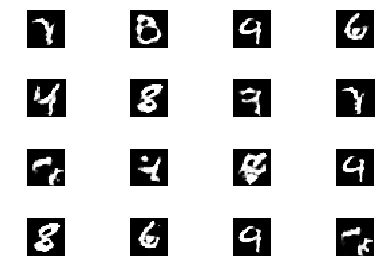

In [239]:
N = 16
noise = np.random.uniform(-1.0, 1.0, size=[N, input_dim]) 
images = G.predict(noise)
import matplotlib.pyplot as plt
for i in range(images.shape[0]):
    plt.subplot(4, 4, i+1)
    image = images[i, :, :, :]
    image = np.reshape(image, [img_rows, img_cols])
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

Notar, sin embargo, que las imágenes producidas son de calidad muy variada, con símbolos que no parecen ser ningún número encontrado en el set de entrenamiento. Es importante recalcar de que a pesar de no ser símbolos reconocibles, pueden pasar como símbolos escritos por alguien, por lo que al menos se puede decir que el modelo logró generar símbolos con espacios negativos consistentes.

Como el autoencoder variacional logró producir imágenes cuyas variaciones correspondían a cualidades encontrados en los sets de imágenes originales, se concluye que la arquitectura utilizada para el autoencoder variacional es más eficiente para poder generar números verosímiles.

Parte f)

En base al análisis hecho en el ítem c), se considera que es más importante poseer un discriminador fiable para poder mejorar el desempeño del modelo completo.

Se procede a crear el mismo modelo que en los ítems anteriores.

In [7]:
from keras.models import Model,Sequential
from keras.layers import LeakyReLU,Conv2D,Dropout,Flatten,Dense
## Discriminator
D = Sequential()
depth = 64
dropout = 0.4
input_shape = (img_rows, img_cols, channel)
D.add(Conv2D(depth*1, (5,5), strides=2, input_shape=input_shape,padding='same', activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(dropout))
D.add(Conv2D(depth*2, (5,5), strides=2, padding='same',activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(dropout))
D.add(Conv2D(depth*4, (5,5), strides=2, padding='same',activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(dropout))
D.add(Flatten())
D.add(Dense(1024,activation=LeakyReLU(alpha=0.2)))
D.add(Dense(1,activation='sigmoid'))

/home/difroggy/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/keras/activations.py:115: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [8]:
from keras.layers import BatchNormalization,Reshape,UpSampling2D,Conv2DTranspose,Activation
## Generator
G = Sequential()
dim = 14
input_dim= 2 #para que sea similar al vAE
G.add(Dense(128, input_dim=input_dim))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Dense(dim*dim*depth))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Reshape((dim, dim, depth)))
G.add(Conv2DTranspose(int(depth/2), (3,3), padding='same',strides=(2,2)))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Conv2DTranspose(int(depth/2), (3,3), padding='same'))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Conv2DTranspose(channel, (3,3), padding='same')) 
G.add(Activation('sigmoid')) 

Luego se crea un subconjunto de entrenamiento que posee imágenes falsas, generadas por el primer autoencoder variacional del ítem 1.1. En teoría, dado que ambos modelos utilizan el mismo número de dimensiones (2) y utilizan los mismo datos de entrenamiento, el espacio latente sería similar en ambos.

In [496]:
xi=np.random.uniform(-1.6,1.6,size=(10000,2,))
xt=np.random.uniform(-1.6,1.6,size=(10000,2,))
yt=np.zeros((10000,1))
noise_output=generator.predict(xi,batch_size=128)
noise_test=generator.predict(xt,batch_size=128)

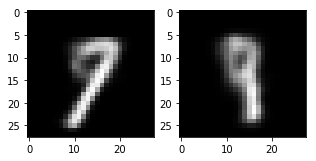

In [494]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(noise_output[31], (28,28))
plt.imshow(curr_img, cmap='gray')

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(noise_output[5000], (28,28))
plt.imshow(curr_img, cmap='gray')

Este conjunto corresponde a las 10,000 imágenes falsas generadas del conjunto original. Luego se concadena este conjunto con un subconjunto de 20,000 imágenes de los datos de entrenamiento original para entrenar al modelo discriminador.

In [501]:
from keras.optimizers import RMSprop
## Discriminator model (police)
optimizer = RMSprop(lr=0.0008, clipvalue=1.0, decay=6e-8)
DM = Sequential()
DM.add(D)
DM.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])

corte=20000
y = np.ones([corte,1])
y_t=np.concatenate((np.ones([len(X_test),1]),np.zeros([10000,1])))
X_train_1=X_train[:corte]
X_train_2=np.concatenate((X_train_1,noise_output))
X_test_1=np.concatenate((X_test,noise_test))
y2=np.concatenate((y,np.zeros([10000,1])))

DM.fit(X_train_2,y2,epochs=10,batch_size=128,validation_data=(X_test_1, y_t))
D.trainable=False
## Adversarial model (Generator->Discriminator)
optimizer = RMSprop(lr=0.0004, clipvalue=1.0, decay=3e-8)
AM = Sequential()
AM.add(G)
AM.add(D)
AM.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])

Train on 30000 samples, validate on 20000 samples
Epoch 1/10
30000/30000 [==============================] - 18s 596us/step - loss: 0.2249 - acc: 0.9037 - val_loss: 0.4204 - val_acc: 0.7863
Epoch 2/10
30000/30000 [==============================] - 11s 383us/step - loss: 0.0646 - acc: 0.9784 - val_loss: 0.0121 - val_acc: 0.9959
Epoch 3/10
30000/30000 [==============================] - 11s 377us/step - loss: 0.0248 - acc: 0.9922 - val_loss: 0.0018 - val_acc: 0.9994
Epoch 4/10
30000/30000 [==============================] - 11s 383us/step - loss: 0.0189 - acc: 0.9948 - val_loss: 5.8645e-04 - val_acc: 0.9999
Epoch 5/10
30000/30000 [==============================] - 11s 379us/step - loss: 0.0116 - acc: 0.9966 - val_loss: 0.0018 - val_acc: 0.9993
Epoch 6/10
30000/30000 [==============================] - 11s 381us/step - loss: 0.0067 - acc: 0.9981 - val_loss: 1.0231e-04 - val_acc: 1.0000
Epoch 7/10
30000/30000 [==============================] - 11s 375us/step - loss: 0.0090 - acc: 0.9985 - val_

Tras haber entrenado este modelo, se entrena el modelo generador con los datos de entrenamiento restantes y con el componente discriminador estático.

In [502]:
train_steps = 5000 #or few if  you want
start = timer()
hist = train_on_steps(X_train[20000:],DM,AM,G,train_steps,128)
end = timer()
diferencia=end-start
print("Tiempo de ejecución: {} seg".format(diferencia))

/home/difroggy/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0: [D loss: 0.003759, acc: 0.996094]  [G loss: 3.857899, acc: 0.468750]
100: [D loss: 0.101716, acc: 0.953125]  [G loss: 1.209484, acc: 0.257812]
200: [D loss: 0.543633, acc: 0.718750]  [G loss: 0.318839, acc: 0.992188]
300: [D loss: 0.513328, acc: 0.699219]  [G loss: 0.757053, acc: 0.476562]
400: [D loss: 0.467830, acc: 0.691406]  [G loss: 1.647101, acc: 0.007812]
500: [D loss: 0.450115, acc: 0.761719]  [G loss: 1.931160, acc: 0.000000]
600: [D loss: 0.387630, acc: 0.812500]  [G loss: 1.334587, acc: 0.070312]
700: [D loss: 0.459741, acc: 0.792969]  [G loss: 1.295198, acc: 0.093750]
800: [D loss: 0.524518, acc: 0.722656]  [G loss: 1.446804, acc: 0.164062]
900: [D loss: 0.499634, acc: 0.734375]  [G loss: 0.713277, acc: 0.531250]
1000: [D loss: 0.492350, acc: 0.734375]  [G loss: 1.527393, acc: 0.062500]
1100: [D loss: 0.313833, acc: 0.867188]  [G loss: 0.700623, acc: 0.546875]
1200: [D loss: 0.380339, acc: 0.808594]  [G loss: 0.740515, acc: 0.562500]
1300: [D loss: 0.784234, acc: 0.66406

Finalmente se muestran las imágenes resultantes.

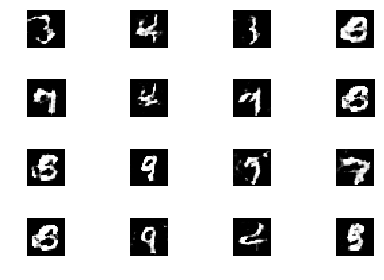

In [509]:
N = 16
noise = np.random.uniform(-1.6, 1.6, size=[N, input_dim]) 
images = G.predict(noise)
import matplotlib.pyplot as plt
for i in range(images.shape[0]):
    plt.subplot(4, 4, i+1)
    image = images[i, :, :, :]
    image = np.reshape(image, [img_rows, img_cols])
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

El generador de imágenes produce símbolos que igualmente trata de emular los datos originales, pero presentando una evidente ilegibilidad en algunos ejemplos.

Parte g)

Primero se vuelve a definir el modelo completo.

In [4]:
from keras.models import Model,Sequential
from keras.layers import LeakyReLU,Conv2D,Dropout,Flatten,Dense
## Discriminator
D = Sequential()
depth = 64
dropout = 0.4
input_shape = (img_rows, img_cols, channel)
D.add(Conv2D(depth*1, (5,5), strides=2, input_shape=input_shape,padding='same', activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(dropout))
D.add(Conv2D(depth*2, (5,5), strides=2, padding='same',activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(dropout))
D.add(Conv2D(depth*4, (5,5), strides=2, padding='same',activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(dropout))
D.add(Flatten())
D.add(Dense(1024,activation=LeakyReLU(alpha=0.2)))
D.add(Dense(1,activation='sigmoid'))

/home/difroggy/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/keras/activations.py:115: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [5]:
from keras.layers import BatchNormalization,Reshape,UpSampling2D,Conv2DTranspose,Activation
## Generator
G = Sequential()
dim = 14
input_dim= 2 #para que sea similar al vAE
G.add(Dense(128, input_dim=input_dim))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Dense(dim*dim*depth))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Reshape((dim, dim, depth)))
G.add(Conv2DTranspose(int(depth/2), (3,3), padding='same',strides=(2,2)))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Conv2DTranspose(int(depth/2), (3,3), padding='same'))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Conv2DTranspose(channel, (3,3), padding='same')) 
G.add(Activation('sigmoid')) 

In [6]:
from keras.optimizers import RMSprop
## Discriminator model (police)
optimizer = RMSprop(lr=0.0008, clipvalue=1.0, decay=6e-8)
DM = Sequential()
DM.add(D)
DM.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
## Adversarial model (Generator->Discriminator)
D.trainable=False #set the discriminator freeze  (fixed params)
optimizer = RMSprop(lr=0.0004, clipvalue=1.0, decay=3e-8)
AM = Sequential()
AM.add(G)
AM.add(D)
AM.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])

Luego se redefinen los pasos de entrenamiento, esta vez en lugar de generar ruido utilizando distribución uniforme, se utiliza una distribución normal.

In [518]:
def train_on_steps2(X_train,DM,AM,G,train_steps,batch_size):
    history = {"d":[],"g":[]}
    for e in range(train_steps):
        # Make generative images
        image_batch = X_train[np.random.randint(0,X_train.shape[0],size=batch_size),:,:,:] #sample images from real data
        noise_gen = np.random.normal(loc=0.0,scale=1.0,size=[batch_size,input_dim]) #sample image from generated data
        generated_images = G.predict(noise_gen) #fake images
        # Train discriminator on generated images
        X = np.concatenate((image_batch, generated_images))
        #create labels
        y = np.ones([2*batch_size,1])
        y[batch_size:,:] = 0
        d_loss  = DM.train_on_batch(X,y)
        history["d"].append(d_loss)
        # train Generator-Discriminator stack on input noise to non-generated output class
        noise_tr = np.random.uniform(-1,1,size=[batch_size,input_dim])
        y = np.ones([batch_size, 1])
        g_loss = AM.train_on_batch(noise_tr, y)
        history["g"].append(g_loss)
        log_mesg = "%d: [D loss: %f, acc: %f]" % (e, d_loss[0], d_loss[1])
        log_mesg = "%s  [G loss: %f, acc: %f]" % (log_mesg, g_loss[0], g_loss[1])
        if(e%100==0):
            print(log_mesg)
    return history
train_steps = 5000 #or few if  you want
start = timer()
hist = train_on_steps(X_train,DM,AM,G,train_steps,128)
end = timer()
diferencia=end-start
print("Tiempo de ejecución: {} seg".format(diferencia))

/home/difroggy/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0: [D loss: 0.688681, acc: 0.523438]  [G loss: 7.163538, acc: 0.000000]
100: [D loss: 0.901339, acc: 0.500000]  [G loss: 1.194566, acc: 0.023438]
200: [D loss: 0.635146, acc: 0.550781]  [G loss: 1.508461, acc: 0.187500]
300: [D loss: 0.696203, acc: 0.644531]  [G loss: 1.350770, acc: 0.117188]
400: [D loss: 0.455618, acc: 0.808594]  [G loss: 1.315257, acc: 0.078125]
500: [D loss: 0.583781, acc: 0.675781]  [G loss: 0.381233, acc: 0.843750]
600: [D loss: 0.466035, acc: 0.753906]  [G loss: 0.948209, acc: 0.171875]
700: [D loss: 0.454894, acc: 0.769531]  [G loss: 1.944651, acc: 0.000000]
800: [D loss: 0.300135, acc: 0.855469]  [G loss: 0.517290, acc: 0.710938]
900: [D loss: 0.334303, acc: 0.843750]  [G loss: 0.956493, acc: 0.257812]
1000: [D loss: 0.441943, acc: 0.816406]  [G loss: 1.043484, acc: 0.320312]
1100: [D loss: 0.367007, acc: 0.843750]  [G loss: 0.890143, acc: 0.437500]
1200: [D loss: 0.441912, acc: 0.777344]  [G loss: 1.512925, acc: 0.265625]
1300: [D loss: 0.314371, acc: 0.85937

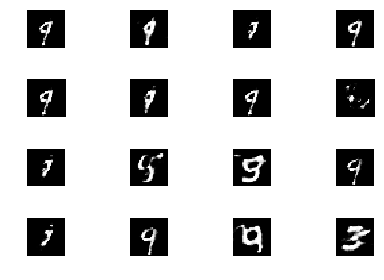

In [523]:
N = 16
noise = np.random.uniform(np.random.normal(loc=0.0,scale=1.6,size=[N,input_dim])) 
images = G.predict(noise)
import matplotlib.pyplot as plt
for i in range(images.shape[0]):
    plt.subplot(4, 4, i+1)
    image = images[i, :, :, :]
    image = np.reshape(image, [img_rows, img_cols])
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

Utilizando una distribución normal, los símbolos generados tienen similitud con las pruebas anteriores, en el sentido de que todas son variaciones bien diversas de símbolos reales, con algunas imágenes que no parecen corresponder a ningún tipo de número.

En base al set de imágenes mostradas, varias de las imágenes parecen provenir de nueves. Esto podría deberse a que al ocupar una distribución normal para generar ruido, se acota también el tipo de entrada al generador y por extensión la salida también es más reducida.

Con distribución uniforme se consideraba un intervalo $[-1,1]$, mientras que en distribución normal el ruido se centra en 0, y a pesar de que el rango de valores es más amplio, es mucho más probable que se utilice durante entrenamiento valores cercanos al centro que en sus extremos.